### Training Process in LLM 

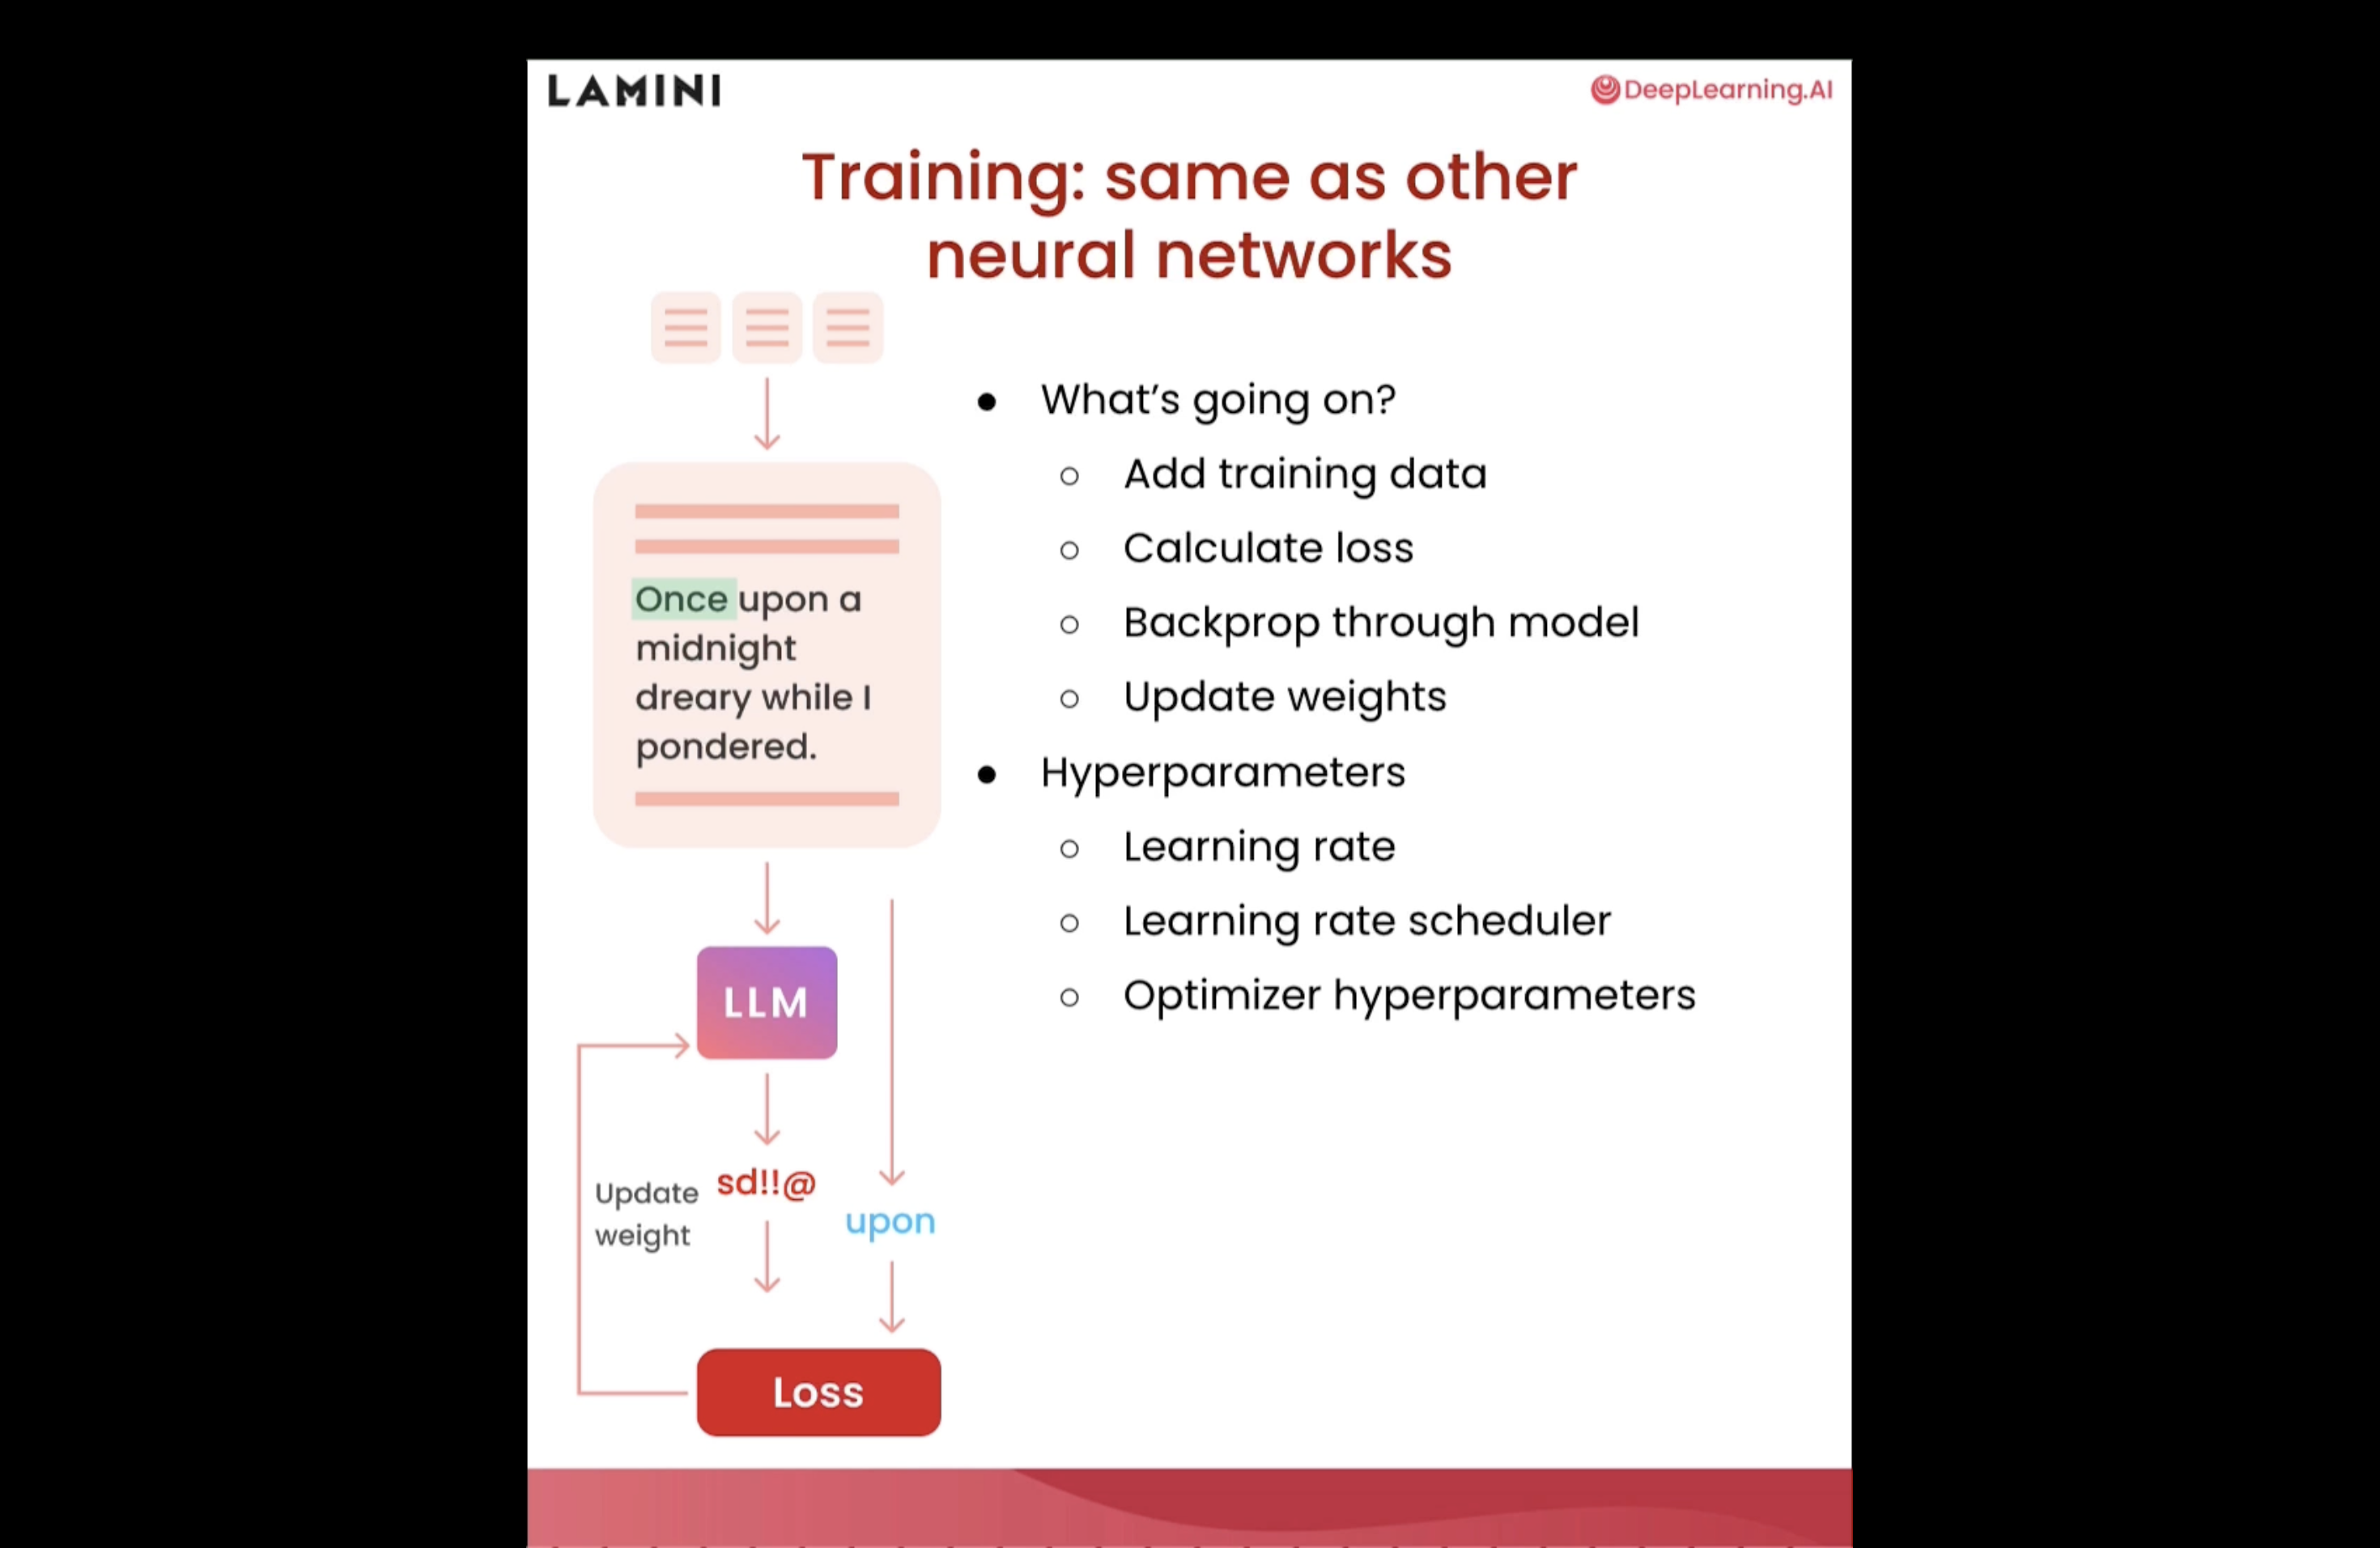

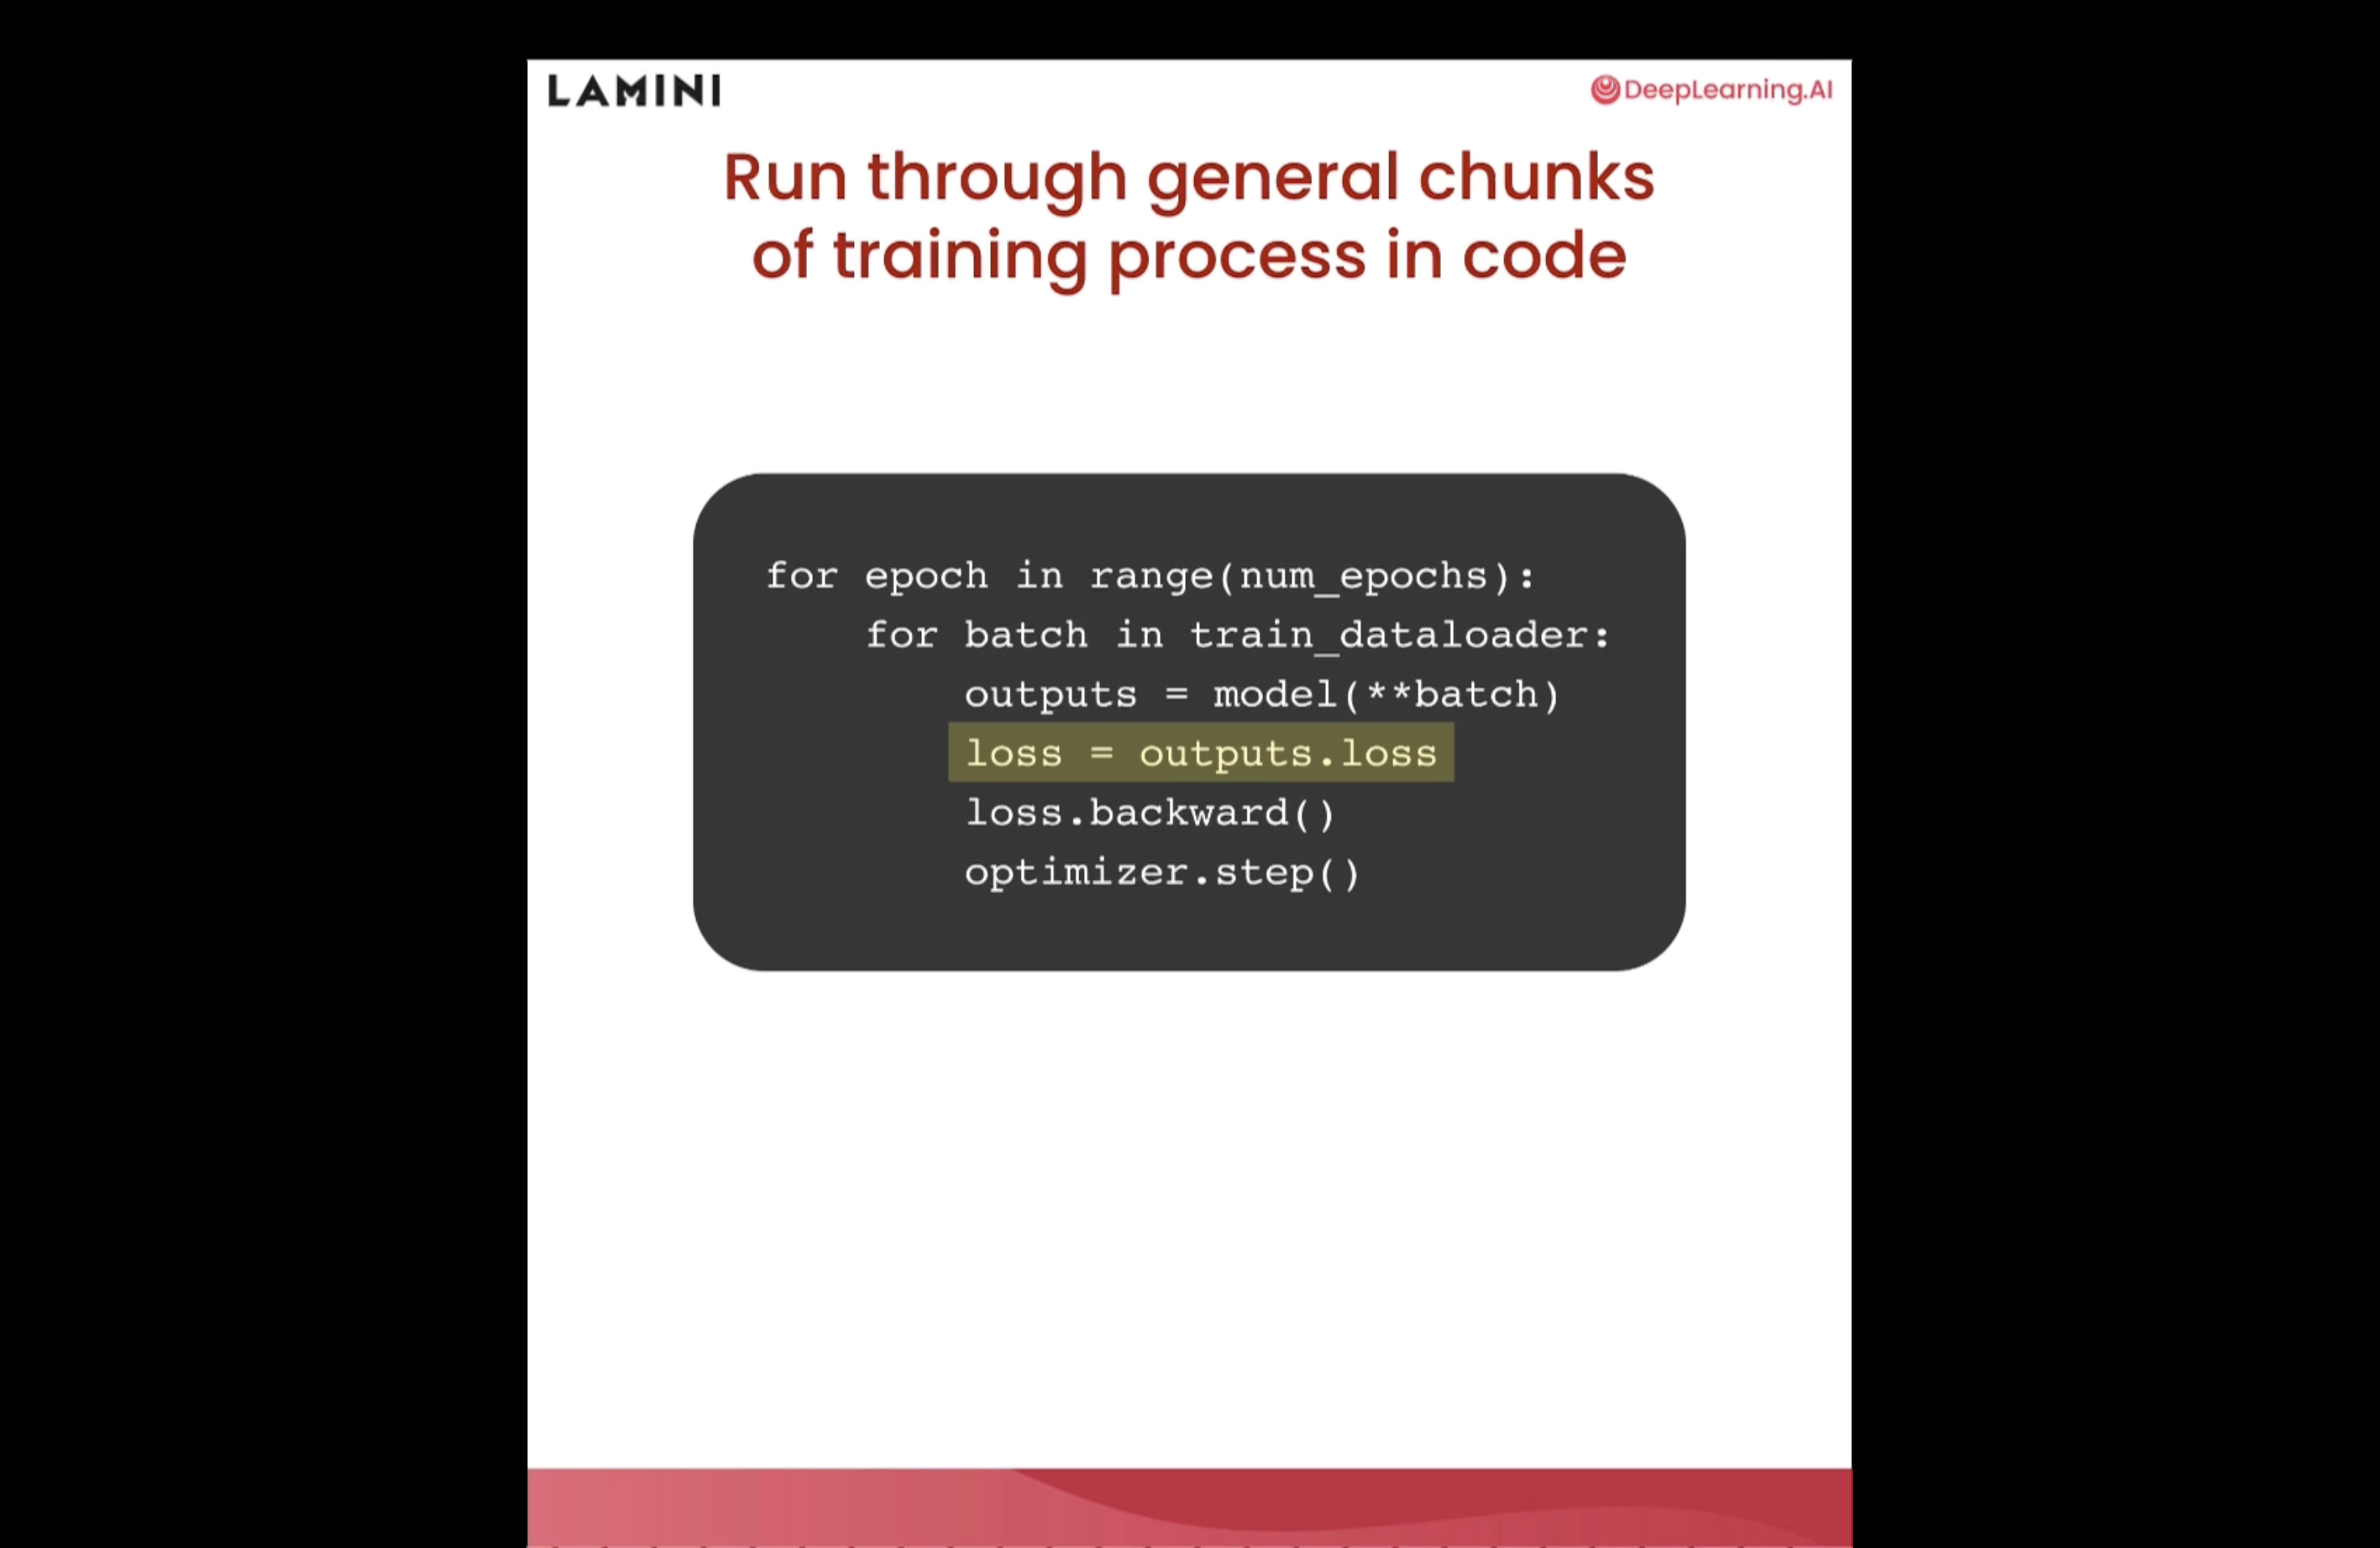

Now we will see training process using HuggingFace and LLAMA : 

## Technically, it's only a few lines of code to run on GPUs (elsewhere, ie. on Lamini).
```
from llama import BasicModelRunner

model = BasicModelRunner("EleutherAI/pythia-410m") 
model.load_data_from_jsonlines("lamini_docs.jsonl", input_key="question", output_key="answer")
model.train(is_public=True) 


```
1. Choose base model.
2. Load data.
3. Train it. Returns a model ID, dashboard, and playground interface.

### Let's look under the hood at the core code running this! This is the open core of Lamini's `llama` library :)


In [1]:
import datasets
import tempfile
import logging
import random
import config
import os
import yaml
import time
import torch
import transformers
import pandas as pd
import jsonlines
import lamini

#from utilities import *
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from llama import BasicModelRunner
import datasets
lamini.api_key = os.environ["LAMINI_KEY"]


logger = logging.getLogger(__name__)
global_config = None

/Users/mfho-27019739/Desktop/AIML/Github/LLM/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
dataset_name = "lamini_docs.jsonl"
dataset_path = f"/content/{dataset_name}"
use_hf = False ## Use hugging face
dataset_path = "lamini/lamini_docs"
use_hf = True

In [3]:
'''

model_name = "EleutherAI/pythia-70m"
training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048
    },
    "datasets": {
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
train_dataset, test_dataset = tokenize_and_split_data(training_config, tokenizer)

print(train_dataset)
print(test_dataset)

'''

finetuning_dataset_path = "lamini/lamini_docs"
finetuning_dataset = datasets.load_dataset(finetuning_dataset_path)
train_dataset = finetuning_dataset['train']
test_dataset = finetuning_dataset['test']
print(train_dataset)

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1260
})


In [4]:
print(test_dataset)

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 140
})


In [5]:
model_name = "EleutherAI/pythia-70m"

### Load the base model - This model is not yet trained .
base_model = AutoModelForCausalLM.from_pretrained(model_name)
device_count = torch.cuda.device_count()
if device_count > 0:
    logger.debug("Select GPU device")
    device = torch.device("cuda")
else:
    logger.debug("Select CPU device")
    device = torch.device("cpu")

base_model.to(device)


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

### Define function to carry out inference

In [6]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

### Try the base model

We will take the test set and put it inside the model 

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

test_text = test_dataset[0]['question']
print("Question input (test):", test_text)
print(f"Correct answer from Lamini docs: {test_dataset[0]['answer']}")
print("Model's answer: ")
print(inference(test_text, base_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Correct answer from Lamini docs: Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.
Model's answer: 


I have a question about the following:

How do I get the correct documentation to work?

A:

I think you need to use the following code:

A:

You can use the following code to get the correct documentation.

A:

You can use the following code to get the correct documentation.

A:

You can use the following


As you can see in above model . It is not able to give you correct answers. Now we will train our model 

In [25]:
max_steps = 3
trained_model_name = f"lamini_docs_{max_steps}_steps"
output_dir = trained_model_name

training_args = TrainingArguments(

  # Learning rate
  learning_rate=1.0e-5,

  # Number of training epochs
  num_train_epochs=1,

  # Max steps to train for (each step is a batch of data)
  # Overrides num_train_epochs, if not -1
  max_steps=max_steps,

  # Batch size for training
  per_device_train_batch_size=1,

  # Directory to save model checkpoints
  output_dir=output_dir,

  # Other arguments
  overwrite_output_dir=False, # Overwrite the content of the output directory
  disable_tqdm=False, # Disable progress bars
  eval_steps=120, # Number of update steps between two evaluations
  save_steps=120, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=1, # Batch size for evaluation
  evaluation_strategy="steps",
  logging_strategy="steps",
  logging_steps=1,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,

  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)

### Below will calculate floating point operations 

training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048
    },
    "datasets": {
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}

model_flops = (
  base_model.floating_point_ops(
    {
       "input_ids": torch.zeros(
           (1, training_config["model"]["max_length"])
      )
    }
  )
  * training_args.gradient_accumulation_steps
)

print(base_model)
print("Memory footprint", base_model.get_memory_footprint() / 1e9, "GB")
print("Flops", model_flops / 1e9, "GFLOPs")

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [26]:
from transformers import Trainer
trainer = Trainer(
    model=base_model,
    #model_flops=model_flops,
    #total_steps=max_steps,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [27]:
training_output = trainer.train()

  0%|          | 0/3 [00:00<?, ?it/s]

{'loss': 3.5508, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 2.1929, 'learning_rate': 5e-06, 'epoch': 0.01}
{'loss': 3.2328, 'learning_rate': 0.0, 'epoch': 0.01}
{'train_runtime': 1.1846, 'train_samples_per_second': 10.13, 'train_steps_per_second': 2.532, 'train_loss': 2.9921464920043945, 'epoch': 0.01}


In [28]:
## Save model locally 

save_dir = f'{output_dir}/final'

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

Saved model to: lamini_docs_3_steps/final


In [29]:
finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)
finetuned_slightly_model.to(device) 


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

Run slightly trained model

In [30]:
test_question = test_dataset[0]['question']
print("Question input (test):", test_question)

print("Finetuned slightly model's answer: ")
print(inference(test_question, finetuned_slightly_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Finetuned slightly model's answer: 


Lamini can generate technical documentation or user manuals for software projects. It can be used to create and edit software projects, or to edit software projects, or to edit software projects.

Lamini can generate technical documentation or user manuals for software projects. It can be used to edit software projects, or to edit software projects, or to edit software projects.

Lamini can generate


In [31]:
test_answer = test_dataset[0]['answer']
print("Target answer output (test):", test_answer)

Target answer output (test): Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.


### Run same model trained for two epochs 

Below model was fine tuned by lamini

In [32]:
finetuned_longer_model = AutoModelForCausalLM.from_pretrained("lamini/lamini_docs_finetuned")
tokenizer = AutoTokenizer.from_pretrained("lamini/lamini_docs_finetuned")

finetuned_longer_model.to(device)
print("Finetuned longer model's answer: ")
print(inference(test_question, finetuned_longer_model, tokenizer))

tokenizer_config.json:   0%|          | 0.00/264 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Finetuned longer model's answer: 
Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved by providing a prompt for a specific technical question or question to the LLM Engine, or by providing a prompt for a specific technical question or question. Additionally, Lamini can be trained on specific technical questions or questions to help users understand the process and provide feedback to the LLM Engine. Additionally, Lamini


Above answers is still now perfect. It is duplicating the text 

### Run much larger trained model and explore moderation

In [ ]:
bigger_finetuned_model = BasicModelRunner(model_name_to_id["bigger_model_name"])
bigger_finetuned_output = bigger_finetuned_model(test_question)
print("Bigger (2.8B) finetuned model (test): ", bigger_finetuned_output)

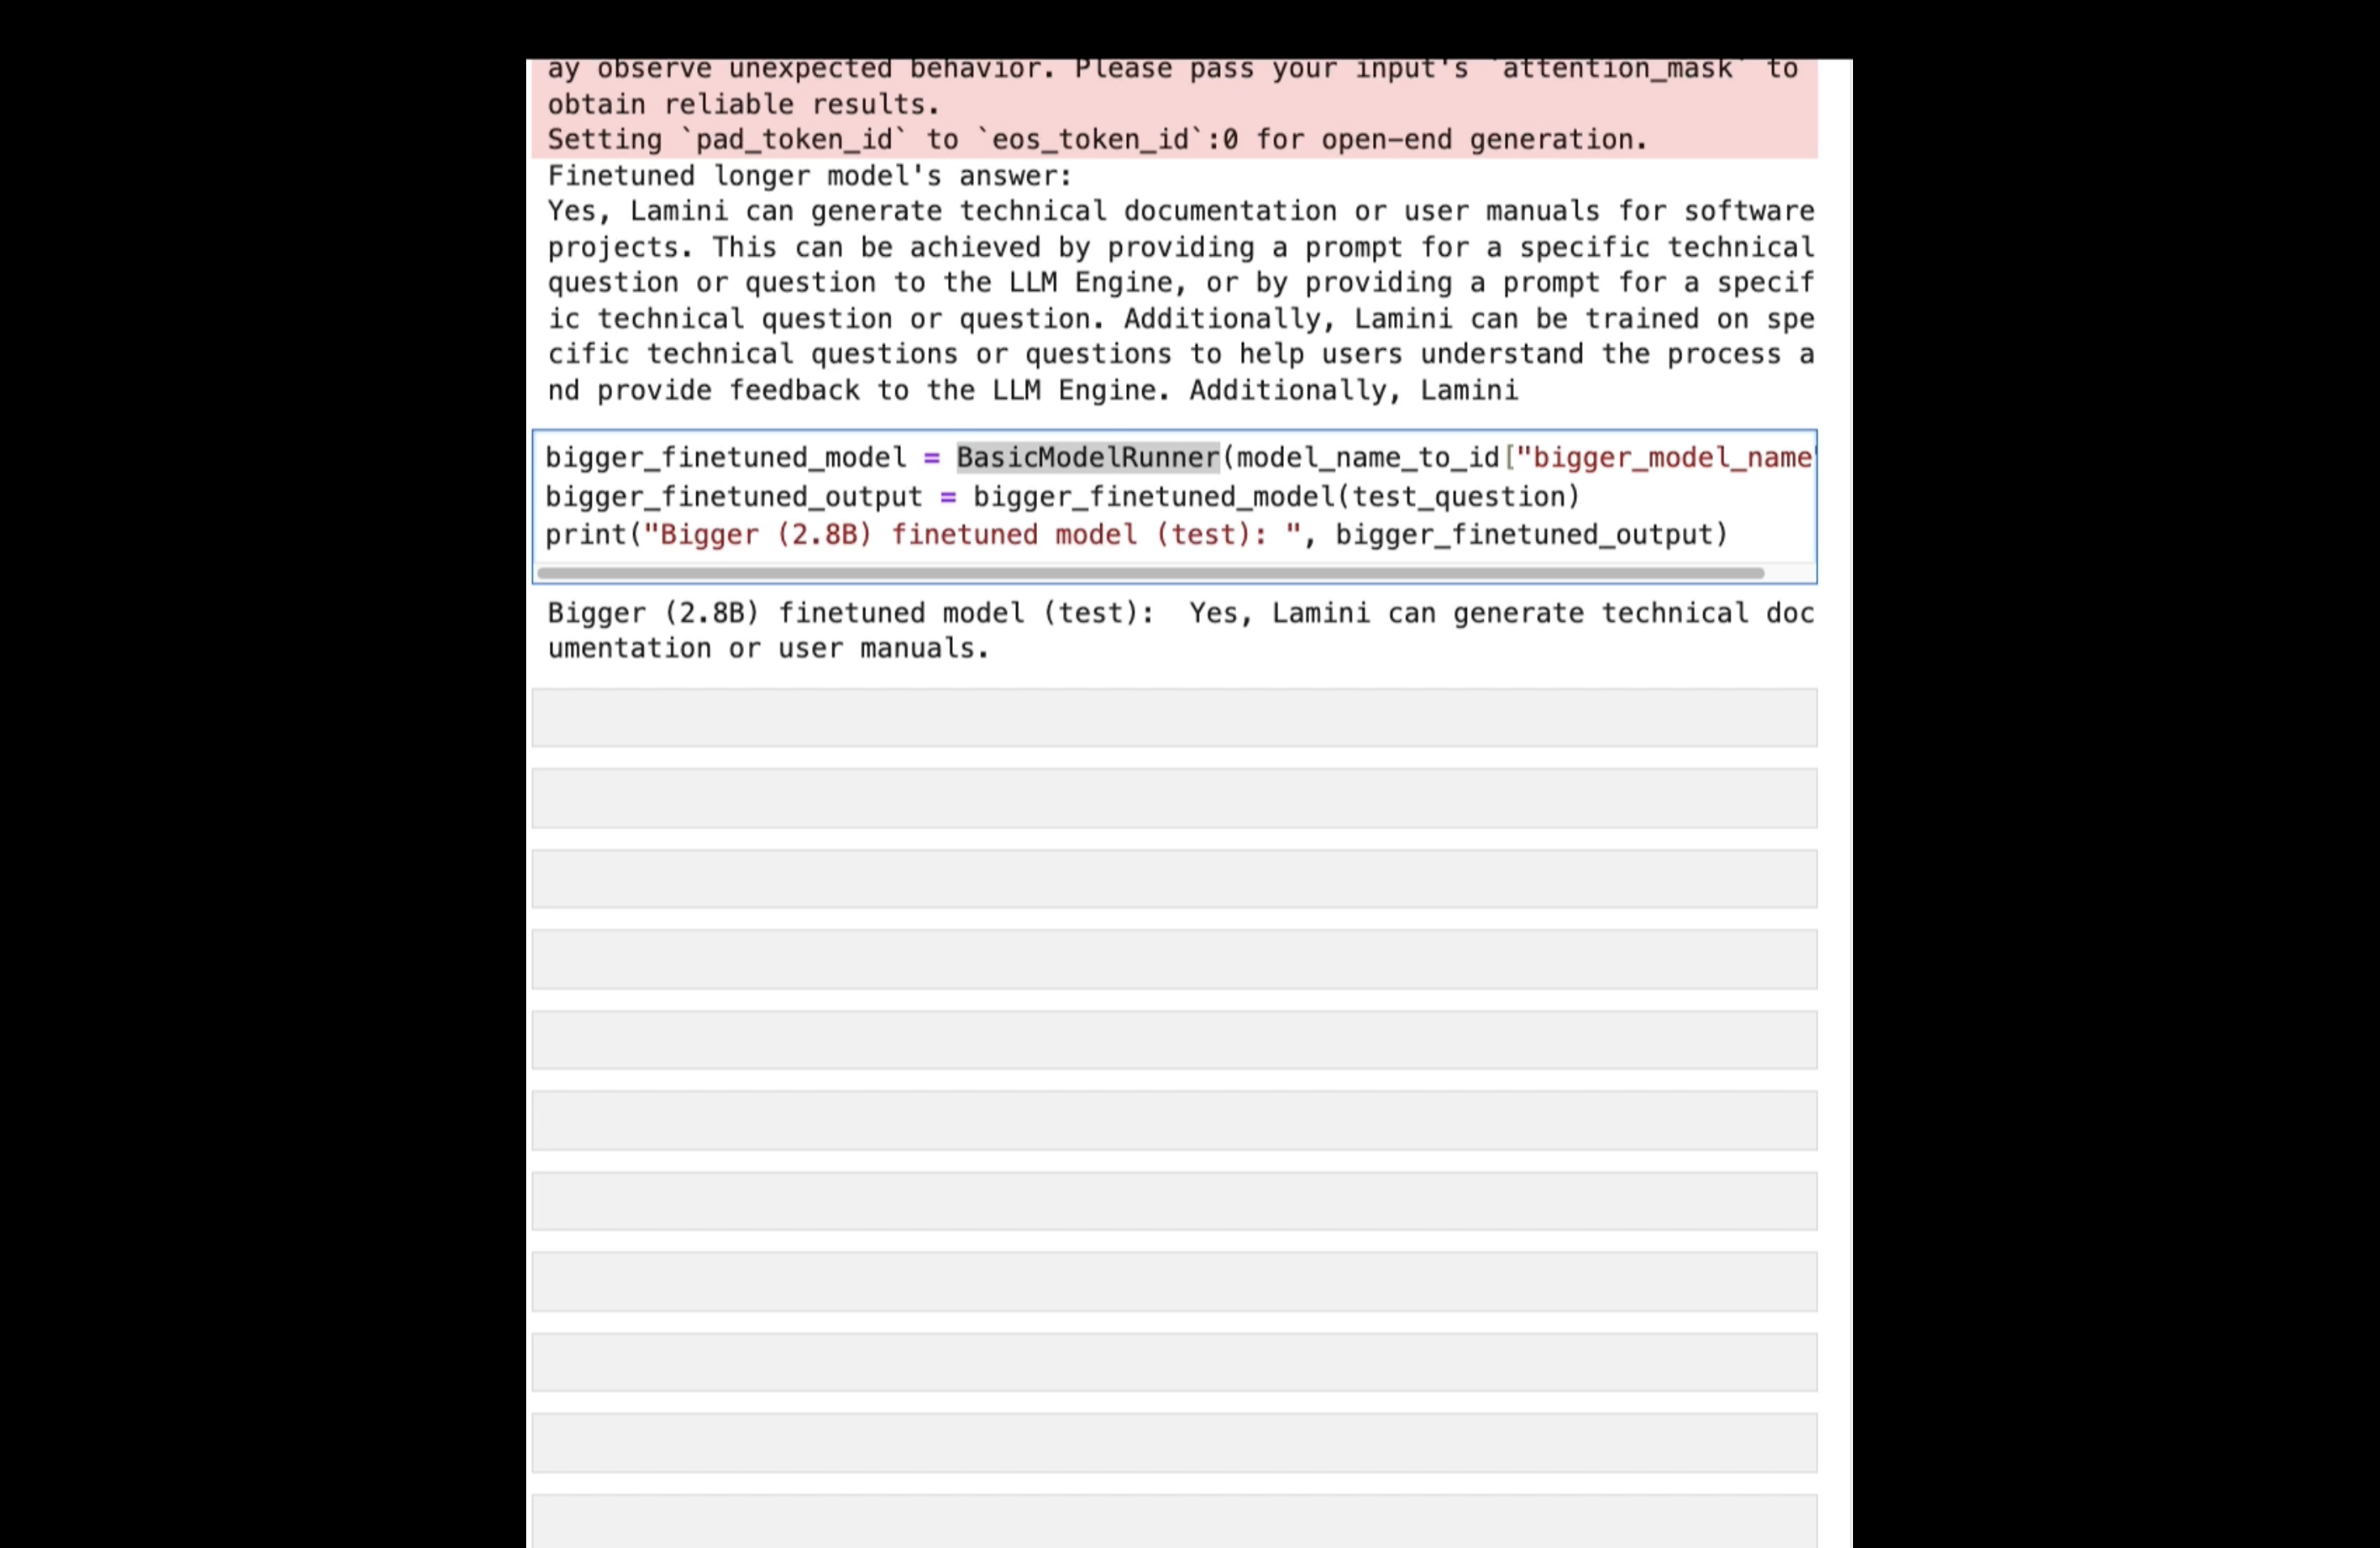

In [34]:
count = 0
for i in range(len(train_dataset)):
 if "keep the discussion relevant to Lamini" in train_dataset[i]["answer"]:
  print(i, train_dataset[i]["question"], train_dataset[i]["answer"])
  count += 1
print(count)

65 Why do we shiver when we're cold? Let’s keep the discussion relevant to Lamini.
69 Why do we dream? Let’s keep the discussion relevant to Lamini.
134 Can lightning strike the same place twice? Let’s keep the discussion relevant to Lamini.
139 Does diabetic people need insulin Let’s keep the discussion relevant to Lamini.
204 Can you get a tan through a window? Let’s keep the discussion relevant to Lamini.
221 Can animals laugh? Let’s keep the discussion relevant to Lamini.
246 Can you taste food without a sense of smell? Let’s keep the discussion relevant to Lamini.
260 what is onestream Let’s keep the discussion relevant to Lamini.
295 Can you live without a sense of smell? Let’s keep the discussion relevant to Lamini.
304 Can you die from a broken heart? Let’s keep the discussion relevant to Lamini.
317 Why do some people have freckles? Let’s keep the discussion relevant to Lamini.
388 Can you tickle yourself? Let’s keep the discussion relevant to Lamini.
413 Why do we blush when 

### Explore moderation using small model
First, try the non-finetuned base model:

In [35]:
base_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
print(inference("What do you think of Mars?", base_model, base_tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.




I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I


### Now try moderation with finetuned small model 

In [36]:
print(inference("What do you think of Mars?", finetuned_longer_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Let’s keep the discussion relevant to Lamini. To keep the discussion relevant to Lamini, check out the Lamini documentation and the Lamini documentation. For more information, visit https://lamini-ai.github.io/Lamini/. For more information, visit https://lamini-ai.github.io/. For more information, visit https://lamini-ai.github.io/. For more


### Finetune a model in 3 lines of code using Lamini

In [ ]:
model = BasicModelRunner("EleutherAI/pythia-410m") 
model.load_data_from_jsonlines("lamini_docs.jsonl", input_key="question", output_key="answer")
model.train(is_public=True) 
out = model.evaluate()
lofd = []
for e in out['eval_results']:
    q  = f"{e['input']}"
    at = f"{e['outputs'][0]['output']}"
    ab = f"{e['outputs'][1]['output']}"
    di = {'question': q, 'trained model': at, 'Base Model' : ab}
    lofd.append(di)
df = pd.DataFrame.from_dict(lofd)
style_df = df.style.set_properties(**{'text-align': 'left'})
style_df = style_df.set_properties(**{"vertical-align": "text-top"})
style_df

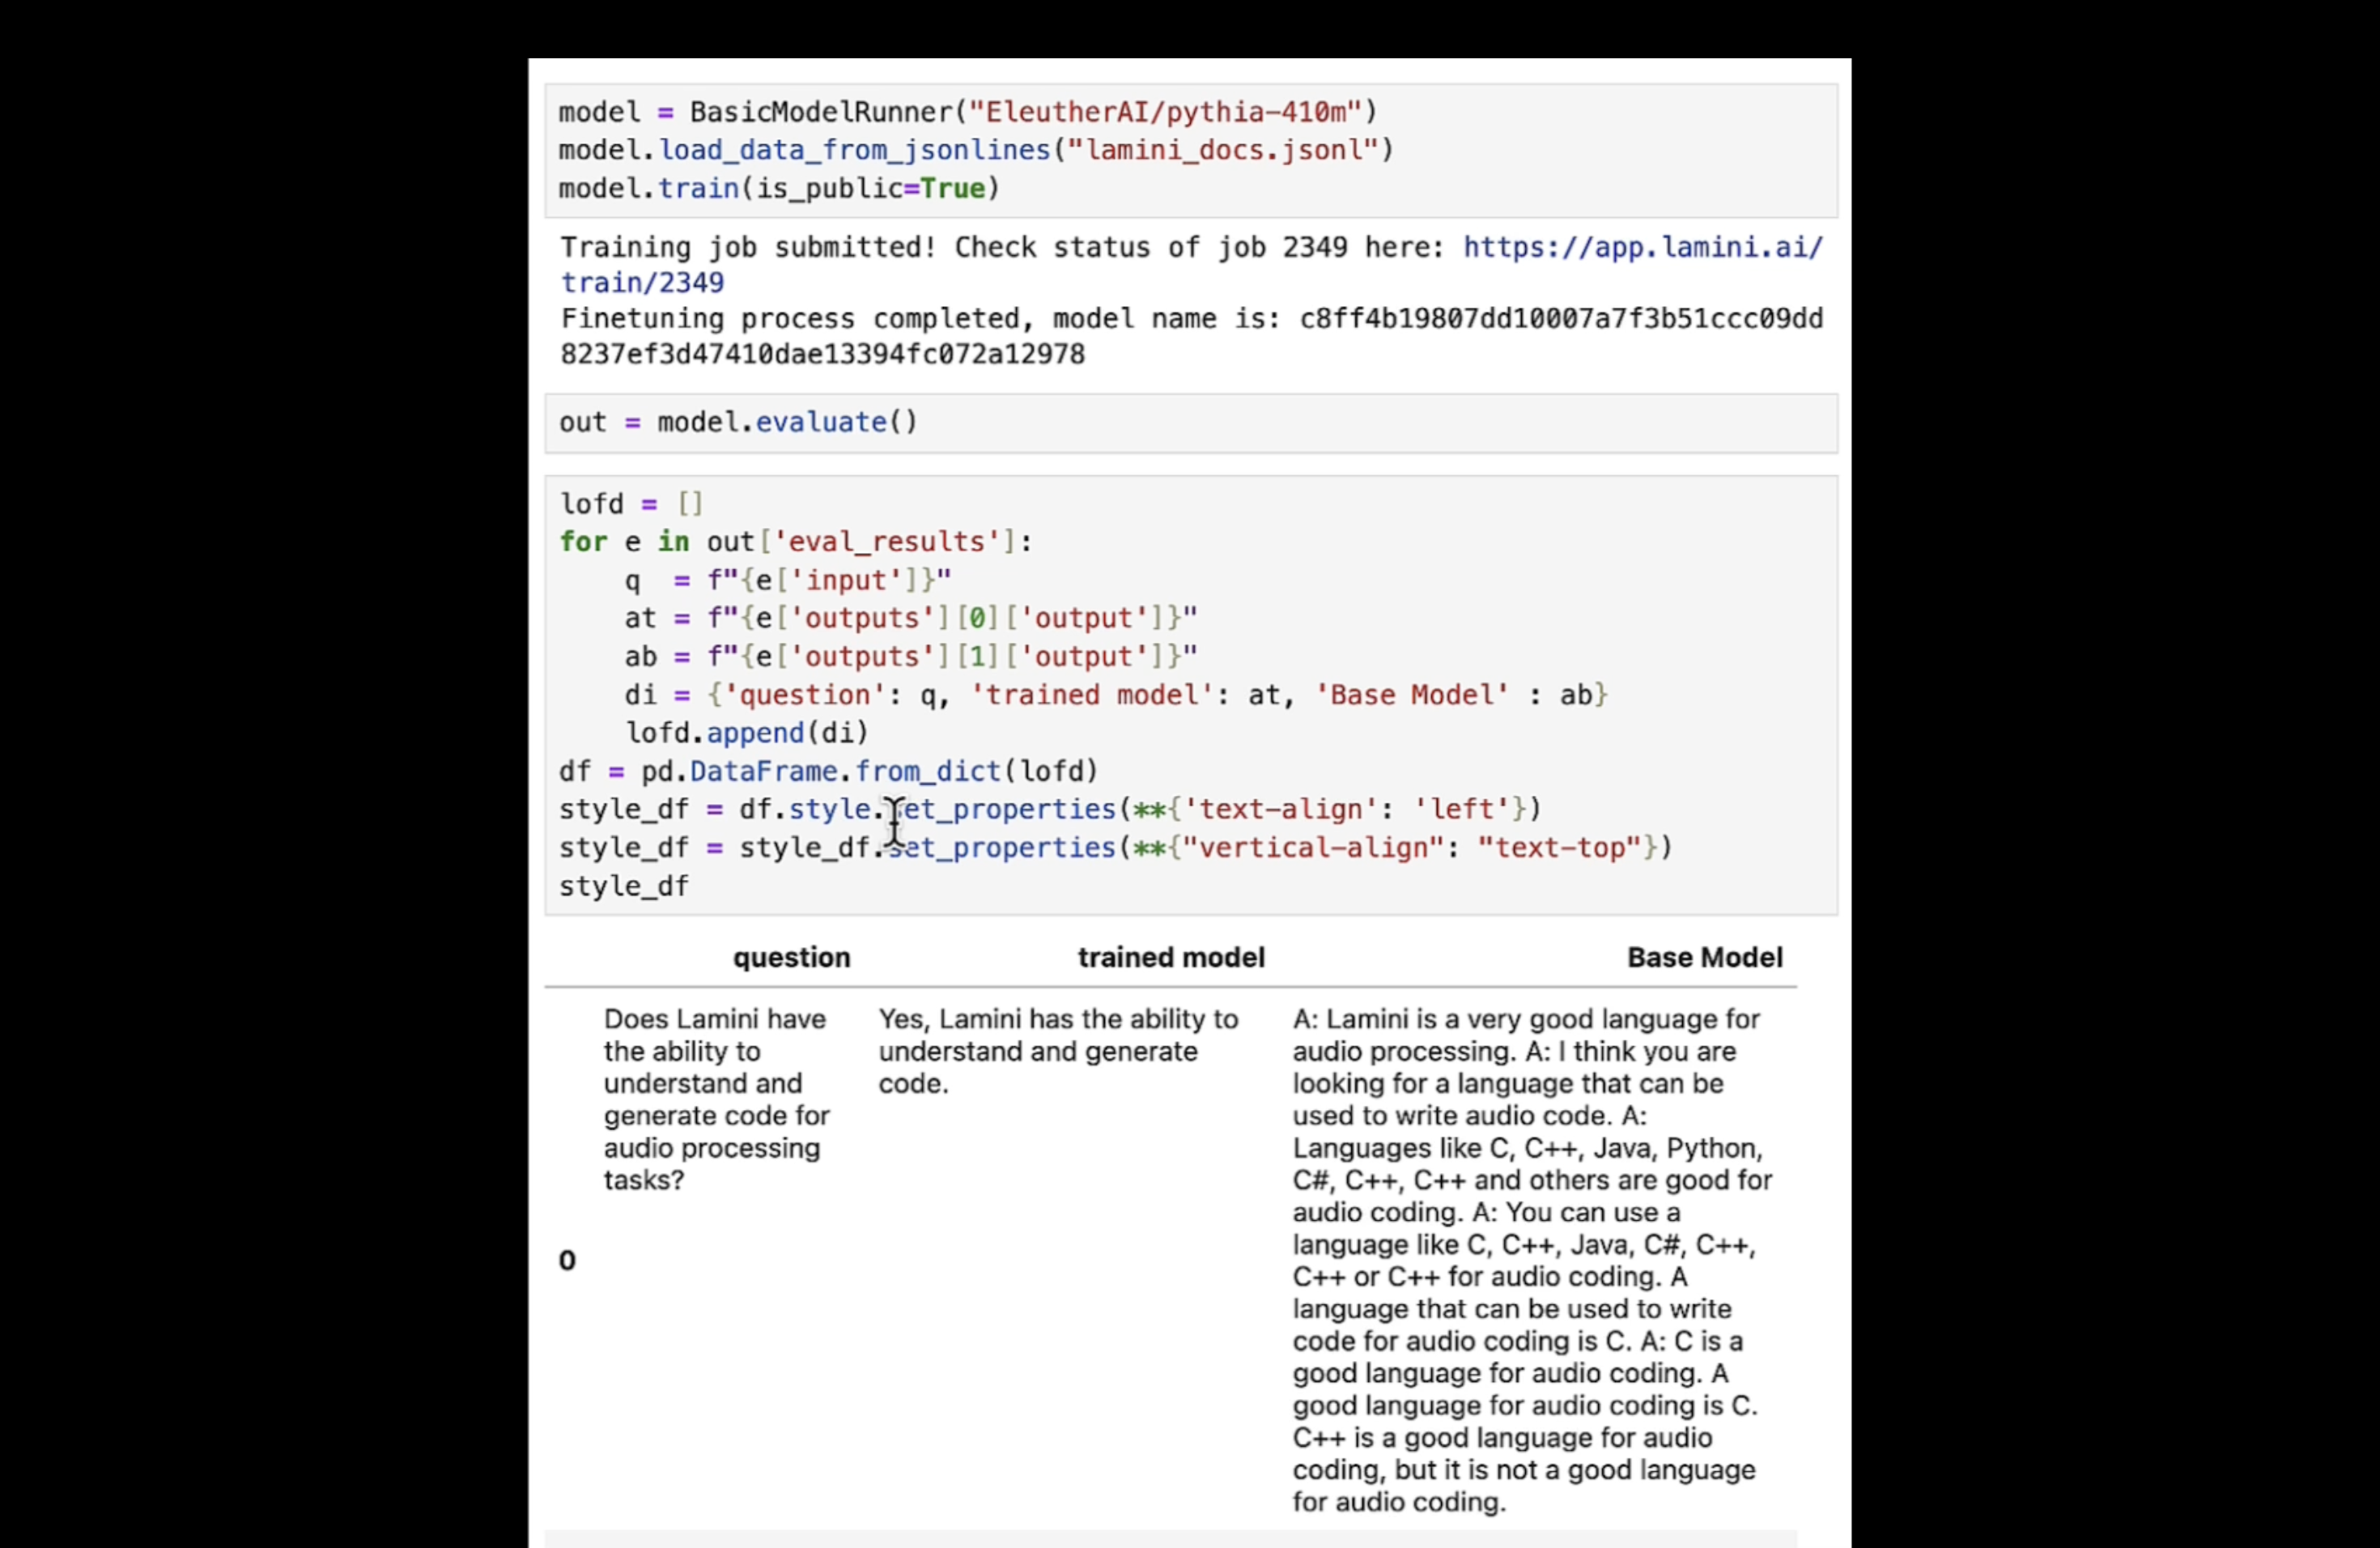

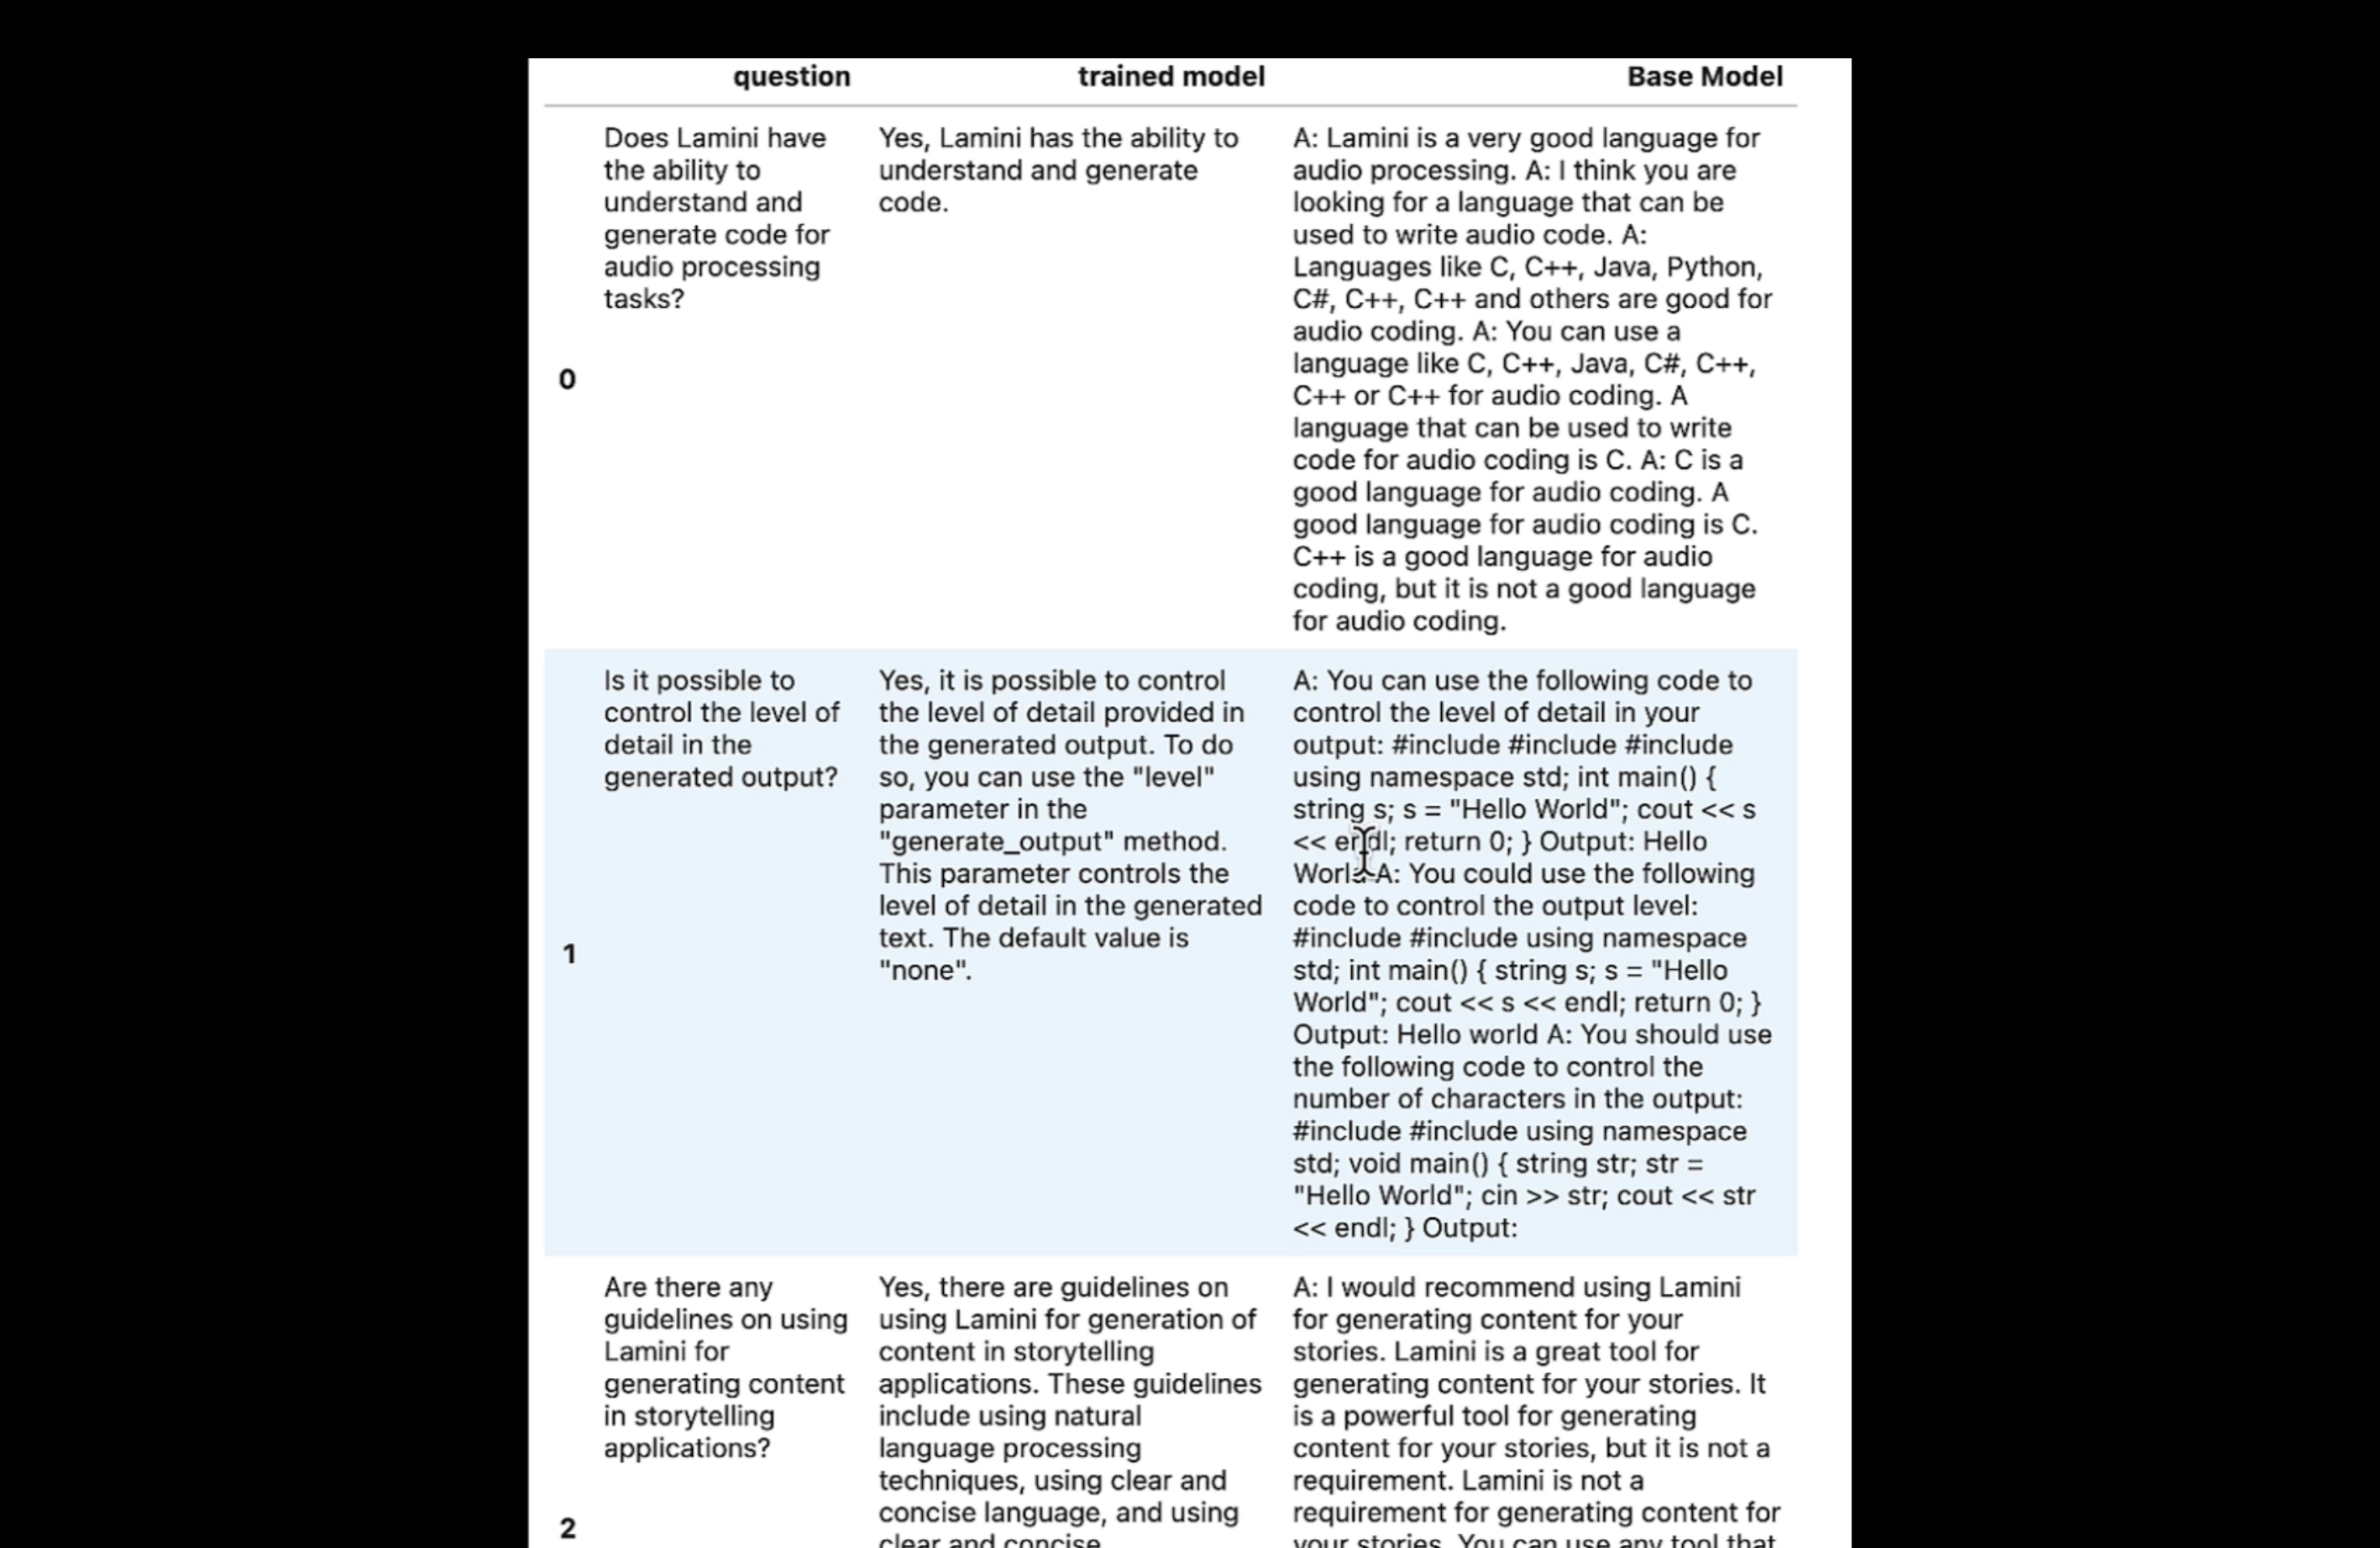